In [122]:
import pandas as pd
import folium
import networkx as nx
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [123]:
# Carica tutti i dataset spinacio
df_fastfood = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/fastfood.csv')
df_pollution = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/pollution.csv')
df_geo = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/US_GeoCode.csv')
df_heart = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/heart_2018.csv')

# carica tutti i dataset franci vece
#df_fastfood = pd.read_csv('C:/Users/f.vece/Documents/Git/progetto-SNA/fastfood.csv')
#df_pollution = pd.read_csv('C:/Users/f.vece/Documents/Git/progetto-SNA/pollution.csv')
#df_geo = pd.read_csv('C:/Users/f.vece/Documents/Git/progetto-SNA/US_GeoCode.csv')
#df_heart = pd.read_csv('C:/Users/f.vece/Documents/Git/progetto-SNA/heart_2018.csv')

# Seleziona solo le colonne che ci interessano in ogni dataset
df_subset_fastfood = df_fastfood[["num", "State", "latitude", "longitude", "name"]]
df_subset_pollution = df_pollution[["Year", "State", "O3 Mean", "CO Mean", "SO2 Mean", "NO2 Mean"]]
df_subset_GEO = df_geo[["latitude", "longitude", "State"]]
df_subset_heart = df_heart[["YEAR", "State", "RATE", "DEATHS"]]

# Dizionario per mappare le sigle delle province ai loro nomi completi
province_mapping = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming"
}

# Sostituisci le sigle delle province con i loro nomi completi
df_subset_fastfood["State"] = df_subset_fastfood["State"].map(province_mapping)
df_subset_heart["State"] = df_subset_heart["State"].map(province_mapping)

/var/folders/j6/1lxb8g2n5l52sjcnr7jwm8yc0000gn/T/ipykernel_964/2455873070.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_fastfood["State"] = df_subset_fastfood["State"].map(province_mapping)
/var/folders/j6/1lxb8g2n5l52sjcnr7jwm8yc0000gn/T/ipykernel_964/2455873070.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_heart["State"] = df_subset_heart["State"].map(province_mapping)


**prendiamo dai dataset solamente quelli del 2018**

In [124]:
df_pollution_2018 = df_subset_pollution[df_subset_pollution['Year'] == 2018]
df_pollution_2018 = df_pollution_2018.groupby('State').mean()

df_heart_2018 = df_subset_heart[df_subset_heart['YEAR'] == 2018]

MERGE DEI DATASET PER RENDERLI SFRUTTABILI USANDO LA MAPPA

In [125]:
fastfood_df = pd.merge(df_subset_fastfood, df_subset_GEO, left_on="State", right_on="State", how="inner")
# Ordina il DataFrame per la colonna 'State' in ordine alfabetico
fastfood_df = fastfood_df.sort_values(by='State')

heart_df = pd.merge(df_heart_2018, df_subset_GEO, left_on="State", right_on="State", how="inner")

pollution_df = pd.merge(df_pollution_2018, df_subset_GEO, left_on="State", right_on="State", how="inner")

#pollution_df.to_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/progetto/pollution_completo.csv', index=False)
#fastfood_df.to_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/progetto/fastfood_completo.csv', index=False)
#heart_df.to_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/progetto/heart_completo.csv', index=False)

CI SERVE SOLAMENTE O3 (OZONO TROPOSFERICO) AL FINE DEL NOSTRO STUDIO

LASCIO DI SEGUITO IL LINK:

https://www.escardio.org/The-ESC/Press-Office/Press-releases/ozone-pollution-is-linked-with-increased-hospitalisations-for-cvd#:~:text=Compared%20to%20two%2Dday%20average,6.52%25%20for%20acute%20myocardial%20infarction.

COSTRUISCO LA MAPPA DEL RAPPORTO DELLE MORTI PER INFARTO PER TROVARE UNA CORRELAZIONE

SPOILER: NON C'è UNA CORRELAZIONE EVIDENTE

In [127]:
# Carica il dataset
heart_data = pd.read_csv('heart_completo.csv')

# Raggruppa i dati per stato e calcola la media del tasso di mortalità
state_rate_mean = heart_data.groupby('State')['RATE'].mean().reset_index()

# Crea la mappa centrata sugli Stati Uniti
m = folium.Map(location=[37.0902, -95.7129], zoom_start=3, zoom_control=False, scrollWheelZoom=False)

usa_geojson_path = '/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/usa_geo.json'
state_boundaries = folium.GeoJson(
    usa_geojson_path,
    name='State Boundaries',
    style_function=lambda feature: {
        'color': 'black',      # Imposta il colore del bordo degli stati a nero
        'weight': 1,           # Spessore del bordo
        'fillColor': 'pink',   # Imposta il colore di riempimento degli stati a rosa
        'fillOpacity': 0.5     # Opacità del riempimento
    }
).add_to(m)

# Crea una mappa coroplètica basata sulla media del tasso di mortalità per stato
choropleth = folium.Choropleth(
    #geo_data='C:/Users/f.vece/Documents/Git/progetto-SNA/usa_geo.json',  # File GeoJSON degli stati degli USA franci vece
    geo_data='/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/usa_geo.json',  # File GeoJSON degli stati degli USA spinacio
    name='choropleth',
    data=state_rate_mean,
    columns=['State', 'RATE'],
    key_on='feature.properties.name',  # Chiave per unire i dati GeoJSON e i dati del DataFrame
    fill_color='YlOrRd',  # Schema di colori (da giallo a rosso)
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Heart attack',
    nan_fill_color='gray',  # Colore per gli stati senza dati
    nan_fill_opacity=0.4,  # Opacità per gli stati senza dati
    bins=5,  # Numero di bin per la mappa coroplètica
    reset=True,  # Resettare la mappa quando si cambiano le impostazioni
    overlay=True,  # Sovrapporre la mappa coroplètica
    control=True,  # Abilita il controllo della mappa coroplètica
    show=True  # Mostra la mappa coroplètica
).add_to(m)

# Aggiungi legenda interattiva
choropleth.add_to(m)

# Aggiungi il controllo della legenda alla mappa
folium.LayerControl().add_to(m)

# Visualizza la mappa
m


In [128]:
# Carica il dataset
pollution_data = pd.read_csv('pollution_completo.csv')

# Raggruppa i dati per stato e calcola la media del tasso di mortalità
state_rate_mean = pollution_data.groupby('State')['O3 Mean'].mean().reset_index()

# Crea la mappa centrata sugli Stati Uniti
m = folium.Map(location=[37.0902, -95.7129], zoom_start=3, zoom_control=False, scrollWheelZoom=False)

usa_geojson_path = '/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/usa_geo.json'
state_boundaries = folium.GeoJson(
    usa_geojson_path,
    name='State Boundaries',
    style_function=lambda feature: {
        'color': 'black',      # Imposta il colore del bordo degli stati a nero
        'weight': 1,           # Spessore del bordo
        'fillColor': 'pink',   # Imposta il colore di riempimento degli stati a rosa
        'fillOpacity': 0.5     # Opacità del riempimento
    }
).add_to(m)

# Crea una mappa coroplètica basata sulla media del tasso di mortalità per stato
choropleth = folium.Choropleth(
    #geo_data='C:/Users/f.vece/Documents/Git/progetto-SNA/usa_geo.json',  # File GeoJSON degli stati degli USA franci vece
    geo_data='/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/usa_geo.json',  # File GeoJSON degli stati degli USA spinacio
    name='choropleth',
    data=state_rate_mean,
    columns=['State', 'O3 Mean'],
    key_on='feature.properties.name',  # Chiave per unire i dati GeoJSON e i dati del DataFrame
    fill_color= 'Blues',  # Cambia lo schema di colori da bianco a blu
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='O3 pollution',
    nan_fill_color='gray',  # Colore per gli stati senza dati
    nan_fill_opacity=0.4,  # Opacità per gli stati senza dati
    bins=5,  # Numero di bin per la mappa coroplètica
    reset=True,  # Resettare la mappa quando si cambiano le impostazioni
    overlay=True,  # Sovrapporre la mappa coroplètica
    control=True,  # Abilita il controllo della mappa coroplètica
    show=True  # Mostra la mappa coroplètica
).add_to(m)

# Aggiungi legenda interattiva
choropleth.add_to(m)

# Aggiungi il controllo della legenda alla mappa
folium.LayerControl().add_to(m)

# Visualizza la mappa
m


ORA PROCEDEREMO CON LO STUDIO DELLE CENTRALITà DEI NODI IN QUALCHE MODO


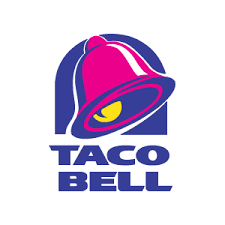
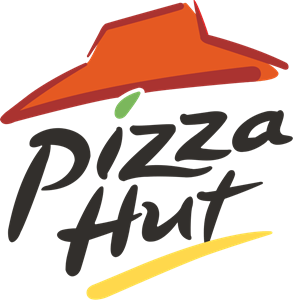
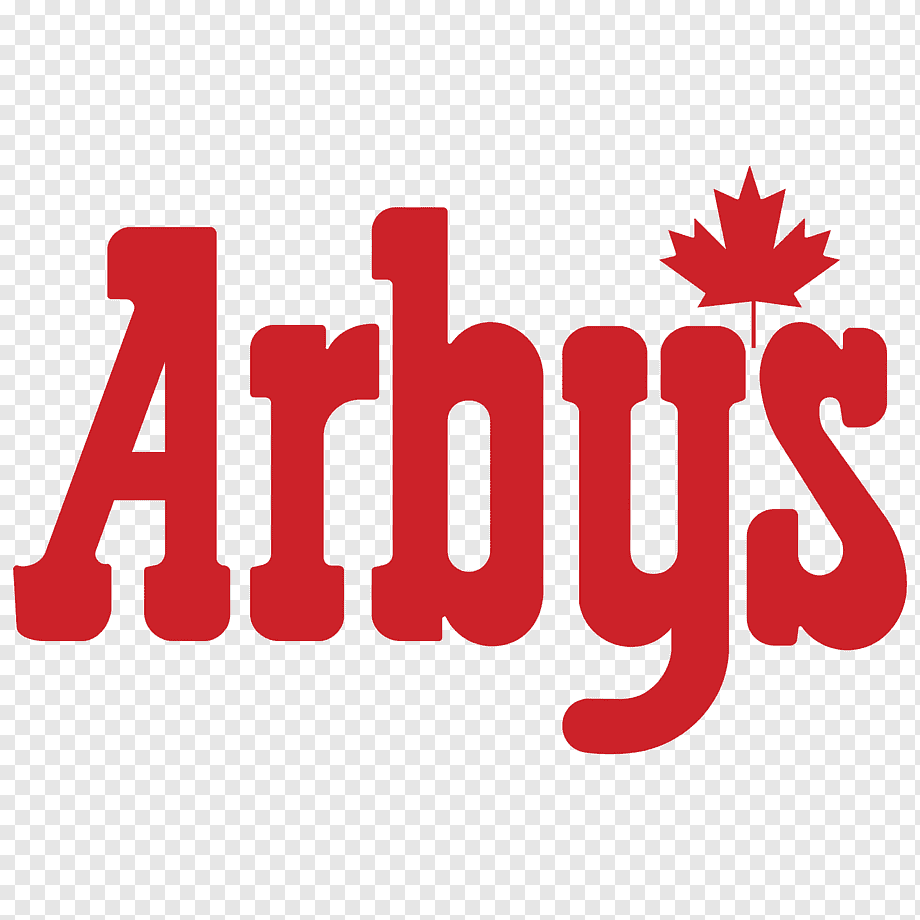
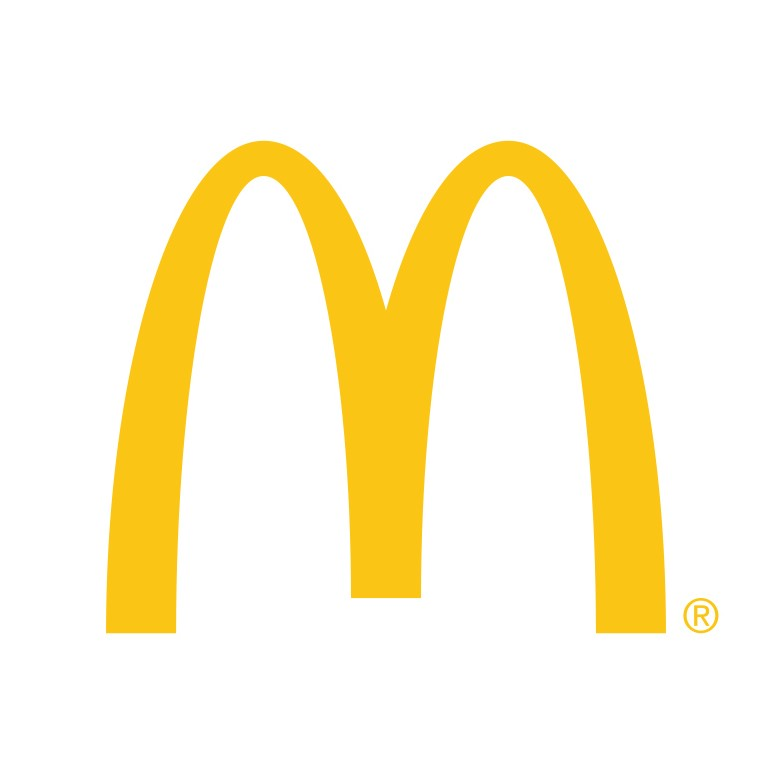
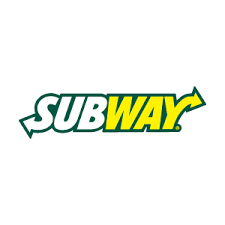
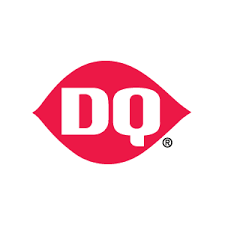
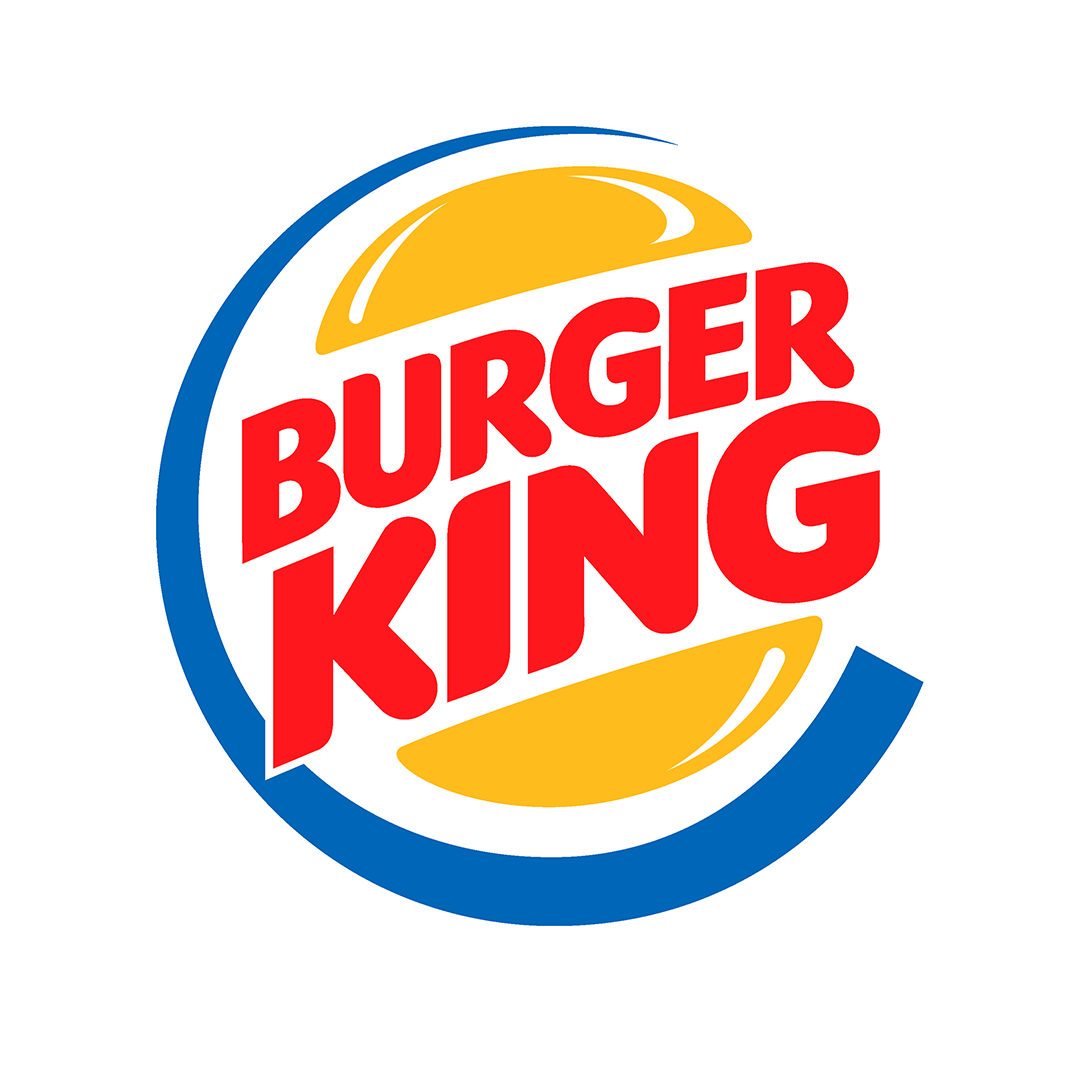
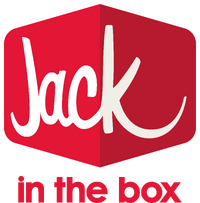
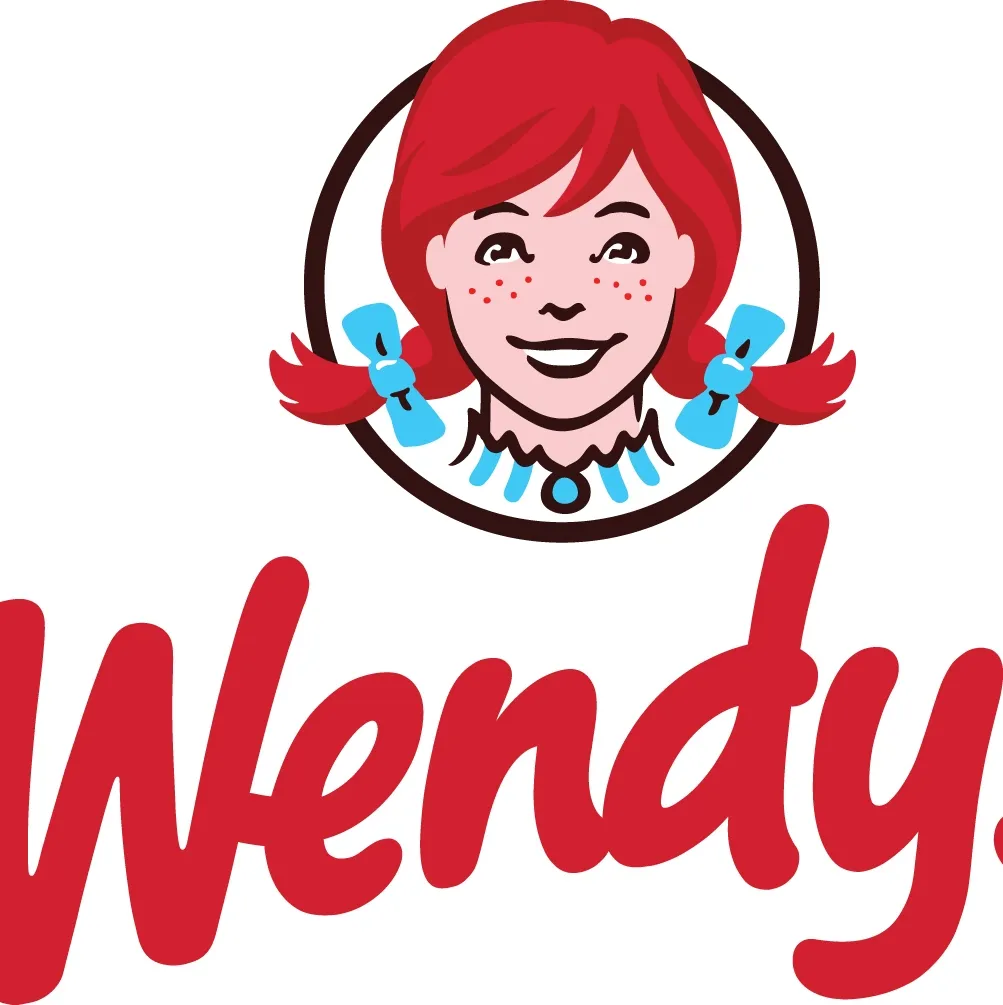
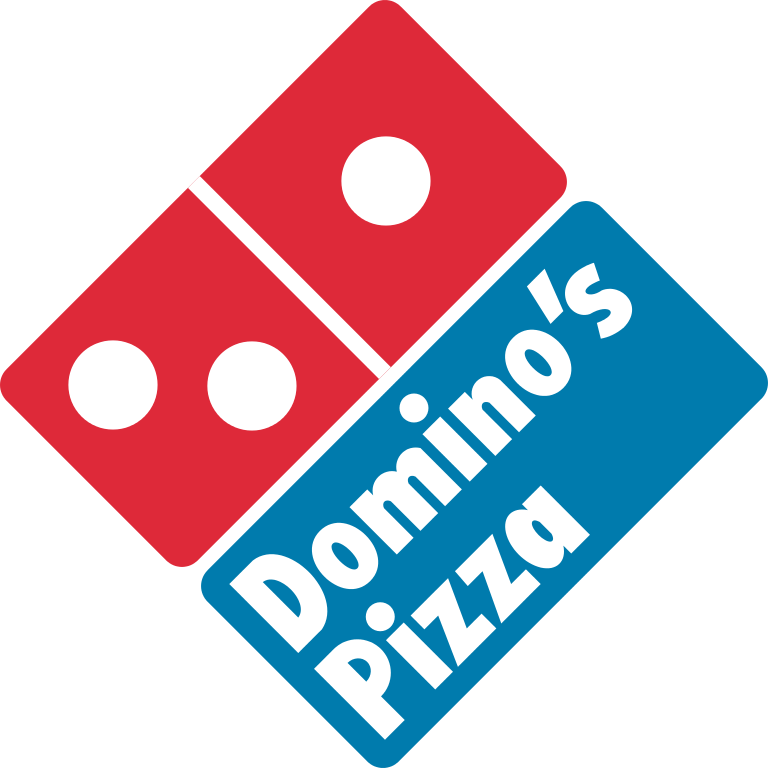

In [129]:
# Leggiamo il file CSV e otteniamo i 10 fast food più frequenti
#fastfood_df = pd.read_csv('C:/Users/f.vece/Documents/Git/progetto-SNA/fastfood_completo.csv') #FRANCI VECE
fastfood_df = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/fastfood_completo.csv') #SPINACIO
top_fastfood = fastfood_df['name'].value_counts().head(10).index.tolist()
altri_fastfood = fastfood_df[~fastfood_df['name'].isin(top_fastfood)]

# Creiamo un grafo
G = nx.Graph()

# Apriamo il file e aggiungiamo nodi e collegamenti al grafo
#with open('C:/Users/f.vece/Documents/Git/progetto-SNA/fastfood_completo.csv', 'r') as file: #FRANCI VECE
with open('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/fastfood_completo.csv', 'r') as file: #SPINACIO
    next(file)  # Salta l'intestazione
    for line in file:
        _, State, _, _, name, _, _ = line.strip().split(',')
        if name in top_fastfood:
            G.add_node(name, type='top_fastfood')
            G.add_node(State, type='state')
            G.add_edge(name, State)

# Crea la mappa centrata sugli Stati Uniti
m = folium.Map(location=[37.0902, -95.7129], zoom_start=3, zoom_control=True, scrollWheelZoom=False)

# Carica il file GeoJSON dei confini degli stati degli USA
usa_geojson_path = '/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/usa_geo.json'
state_boundaries = folium.GeoJson(
    usa_geojson_path,
    name='State Boundaries',
    style_function=lambda feature: {
        'color': 'black',      # Imposta il colore del bordo degli stati a nero
        'weight': 1,           # Spessore del bordo
        'fillColor': 'pink',   # Imposta il colore di riempimento degli stati a rosa
        'fillOpacity': 0.5     # Opacità del riempimento
    }
).add_to(m)

# Aggiungi il layer dei confini degli stati alla mappa
state_boundaries.add_to(m)

randomCoordinates=[]

# Funzione per generare coordinate casuali intorno alla mappa americana

def random_coordinates_around_usa(num_points):
    # Centro degli Stati Uniti
    lat_center = 37.0902
    lon_center = -95.7129
    
    # Semilati dell'ellisse che circonda gli Stati Uniti (approssimativi)
    lat_semi_major_axis = 24
    lon_semi_major_axis = 57
    
    # Calcola l'angolo tra ogni punto
    angle_step = 2 * math.pi / num_points
    
    # Lista per memorizzare le coordinate
    random_coordinates = []
    
    # Genera coordinate equidistanti lungo l'ovale
    for i in range(num_points):
        angle = i * angle_step
        lat = lat_center + lat_semi_major_axis * math.cos(angle)
        lon = lon_center + lon_semi_major_axis * math.sin(angle)
        random_coordinates.append((lat, lon))
    
    return random_coordinates

# Esempio di utilizzo
num_points = 11  # Numero di punti desiderato
coordinates = random_coordinates_around_usa(num_points)


# Aggiungi il nodo 'altri fastfood' alla mappa come marker con coordinate casuali intorno alla mappa americana
altri_fastfood_node = coordinates[0]
folium.Marker(
    location=altri_fastfood_node,
    popup='Altri Fast Food',
    icon=folium.Icon(color='green')
).add_to(m)

# Aggiungi i nodi fast food alla mappa come marker con coordinate casuali intorno alla mappa americana
i=1
for node in G.nodes():
    iconPath="Logos/" + node + ".png"
    if G.nodes[node]['type'] == 'top_fastfood':
        folium.Marker(
            location=coordinates[i],
            popup=node,
            icon=folium.CustomIcon(icon_image=iconPath, icon_size=(40,40))
        ).add_to(m)
        i+=1

for state in G.nodes():
    if G.nodes[state]['type'] == 'state':
        state_loc = (
            fastfood_df.loc[fastfood_df['State'] == state, 'latitude_y'].iloc[0],
            fastfood_df.loc[fastfood_df['State'] == state, 'longitude_y'].iloc[0]
        )
        folium.CircleMarker(
            location=state_loc,
            radius=0.01,
            color='black',
            fill=True,
            fill_color='black',
            fill_opacity=0.7
        ).add_to(m)

for state in G.nodes():
    i=1
    if G.nodes[state]['type'] == 'state':
        state_loc = (fastfood_df.loc[fastfood_df['State'] == state, 'latitude_y'].iloc[0], fastfood_df.loc[fastfood_df['State'] == state, 'longitude_y'].iloc[0])
        for fastfood_name in top_fastfood:
            fast_food_loc = (coordinates[i][0], coordinates[i][1])
            folium.PolyLine([fast_food_loc, state_loc], color="grey", weight=0.6, opacity=0.7).add_to(m)
            i+=1

# Collega gli stati al nodo 'altri_fastfood_node' con archi grigi
for state in G.nodes():
    if G.nodes[state]['type'] == 'state':
        state_loc = (fastfood_df.loc[fastfood_df['State'] == state, 'latitude_y'].iloc[0], fastfood_df.loc[fastfood_df['State'] == state, 'longitude_y'].iloc[0])
        folium.PolyLine([altri_fastfood_node, state_loc], color="grey", weight=0.6, opacity=0.7).add_to(m)

# Visualizza la mappa
m

In [ ]:
ff_df = pd.read_csv('fastfood_completo.csv')
# Conta il numero di fast food per stato
fastfood_per_state = ff_df['State'].value_counts()
print(fastfood_per_state)

             State  McDonald's  Taco Bell  Burger King  Subway  Arby's  \
0          Alabama           0          3            0       0       0   
1           Alaska           1          3            0       4       1   
2          Arizona          58         53           20      16      19   
3         Arkansas          18         16            3      10       8   
4       California         155        123          128      57      18   
5         Colorado           7         27            8      16      13   
6      Connecticut          10          4            4      17       1   
7         Delaware           5          4            1       3      11   
8          Florida         137         75           48      18      47   
9          Georgia         100         44           17      36      31   
10          Hawaii          12          1            4       0       0   
11           Idaho           3          2            3      10       2   
12        Illinois          77        

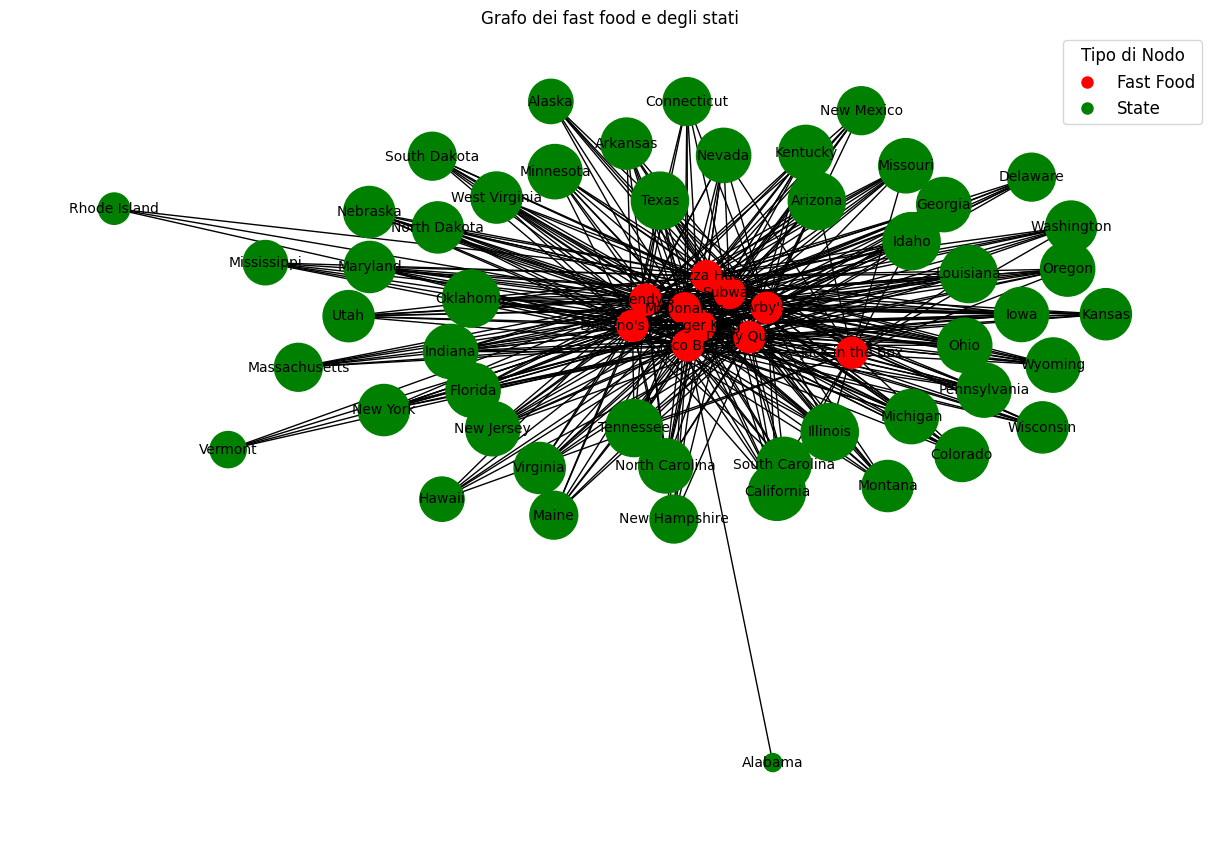

In [175]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# Leggi il file CSV
fastfood_df = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/fastfood_completo.csv')

# Ottieni i 20 fast food più frequenti
top_fastfood = fastfood_df['name'].value_counts().head(10).index.tolist()

# Inizializza un dizionario per contenere i conteggi per stato per ciascun fast food
fastfood_counts_by_state = {'State': fastfood_df['State'].unique()}  # Inizializza con gli stati unici

# Per ogni fast food nella top 20, calcola il conteggio per stato
for fastfood in top_fastfood:
    counts = fastfood_df[fastfood_df['name'] == fastfood].groupby('State').size()
    # Crea una lista di conteggi per fast food, in cui l'ordine degli stati corrisponde all'ordine nel dataframe
    counts_list = [counts.get(state, 0) for state in fastfood_counts_by_state['State']]
    fastfood_counts_by_state[fastfood] = counts_list

# Costruisci un dataframe dai conteggi
fastfood_counts_df = pd.DataFrame(fastfood_counts_by_state)

print(fastfood_counts_df)

# Inizializza un grafo
G = nx.Graph()

# Aggiungi nodi per i top fast food e gli stati
for fastfood in top_fastfood:
    G.add_node(fastfood, type='fastfood')
    
for state in fastfood_df['State'].unique():
    G.add_node(state, type='state')

# Aggiungi archi tra i top fast food e gli stati
for _, row in fastfood_df.iterrows():
    if row['name'] in top_fastfood:
        G.add_edge(row['name'], row['State'])

# Calcola la centralità del grado dei nodi 'State'
state_degree_centrality = nx.degree_centrality(G)
state_centrality_df = pd.DataFrame(state_degree_centrality.items(), columns=['State', 'Degree Centrality'])
state_centrality_filtered_df = state_centrality_df[state_centrality_df['State'].isin(fastfood_df['State'].unique())]
print(state_centrality_filtered_df)


# Calcola la grandezza dei nodi "State" in base al loro valore di Degree Centrality
state_node_size = [state_centrality_filtered_df[state_centrality_filtered_df['State'] == state]['Degree Centrality'].values[0] * 10000
                   for state in fastfood_df['State'].unique()]

# Disegna il grafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

# Disegna i nodi con colori e dimensioni specificati
nx.draw(G, pos, with_labels=True, node_color=[node_colors[G.nodes[node]['type']] for node in G.nodes()],
        node_size=[state_node_size.pop(0) if G.nodes[node]['type'] == 'state' else 500 for node in G.nodes()],
        font_size=10, edge_color='black')

# Crea la legenda
legend_entries = [plt.Line2D([0], [0], marker='o', color='w', label=node_labels[label], 
                              markerfacecolor=color, markersize=10) 
                  for label, color in node_colors.items()]
plt.legend(handles=legend_entries, title='Tipo di Nodo', title_fontsize='large', fontsize='large')

plt.title('Grafo dei fast food e degli stati')
plt.show()




NON ESEGUIRE QUESTA PARTE DI CODICE SOTTO

In [164]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# Leggi il file CSV
fastfood_df = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/fastfood_completo.csv')

# Ottieni i 20 fast food più frequenti
top_fastfood = fastfood_df['name'].value_counts().head(10).index.tolist()

# Inizializza un dizionario per contenere i conteggi per stato per ciascun fast food
fastfood_counts_by_state = {'State': fastfood_df['State'].unique()}  # Inizializza con gli stati unici

# Per ogni fast food nella top 20, calcola il conteggio per stato
for fastfood in top_fastfood:
    counts = fastfood_df[fastfood_df['name'] == fastfood].groupby('State').size()
    # Crea una lista di conteggi per fast food, in cui l'ordine degli stati corrisponde all'ordine nel dataframe
    counts_list = [counts.get(state, 0) for state in fastfood_counts_by_state['State']]
    fastfood_counts_by_state[fastfood] = counts_list

# Costruisci un dataframe dai conteggi
fastfood_counts_df = pd.DataFrame(fastfood_counts_by_state)

print(fastfood_counts_df)

# Crea un grafo
G = nx.Graph()

# Aggiungi nodi e collegamenti al grafo
for state in fastfood_counts_df['State']:
    G.add_node(state, type='state', size=fastfood_counts_df.loc[fastfood_counts_df['State'] == state].iloc[0, 1:].sum())  # Aggiungi nodi degli stati con un attributo 'size'

for fastfood, counts in fastfood_counts_df.iteritems():
    if fastfood != 'State':
        G.add_node(fastfood, type='top_fastfood')
        for state, count in zip(fastfood_counts_df['State'], counts):
            if count > 0:
                G.add_edge(fastfood, state)

# Aggiungi un nodo per rappresentare gli "altri fast food" e lo collega agli stati
G.add_node('Altri Fast Food', type='altri_fastfood')
for state in fastfood_per_state.index:
    if state not in fastfood_counts_df['State'].tolist():
        G.add_node(state, type='state')
        G.add_edge('Altri Fast Food', state)

# Disegna il grafo
plt.figure(figsize=(15, 10))  # Impostiamo le dimensioni della figura
pos = nx.spring_layout(G, seed=42)  # Posizioni dei nodi
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes() if G.nodes[node]['type'] == 'state'], 
                       node_color='lightgreen', node_size=[G.nodes[node]['size'] * 100 for node in G.nodes()], 
                       label='State', edgecolors='black')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes() if G.nodes[node]['type'] == 'top_fastfood'], 
                       node_color='blue', node_size=300, label='Top Fast Food', edgecolors='black')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes() if G.nodes[node]['type'] == 'altri_fastfood'], 
                       node_color='orange', node_size=300, label='Altri Fast Food', edgecolors='black')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
plt.title('Grafo dei fast food e degli stati')
plt.legend()
plt.axis('off')  # Rimuoviamo gli assi
plt.tight_layout()  # Ottimizziamo il layout
plt.show()


             State  McDonald's  Taco Bell  Burger King  Subway  Arby's  \
0          Alabama           0          3            0       0       0   
1           Alaska           1          3            0       4       1   
2          Arizona          58         53           20      16      19   
3         Arkansas          18         16            3      10       8   
4       California         155        123          128      57      18   
5         Colorado           7         27            8      16      13   
6      Connecticut          10          4            4      17       1   
7         Delaware           5          4            1       3      11   
8          Florida         137         75           48      18      47   
9          Georgia         100         44           17      36      31   
10          Hawaii          12          1            4       0       0   
11           Idaho           3          2            3      10       2   
12        Illinois          77        

AttributeError: 'DataFrame' object has no attribute 'iteritems'

GRAFICI (ISTOGRAMMA) CORRELAZIONE TOP STATI (ASSE X) BLU O3 E ROSSO HEART ATTACK, PRIMA DI FARE QUESTO ABBIAMO NORMALIZZATO PER LA FORMULA MAX-MIN CHE CI PERMETTE DI CORRELARE MEGLIO I DUE VALORI, RIPORTO DI SEGUITO LA FORMULA.

X(norm)=(X-X(min)/X(max)-X(min))*(max-min)+min

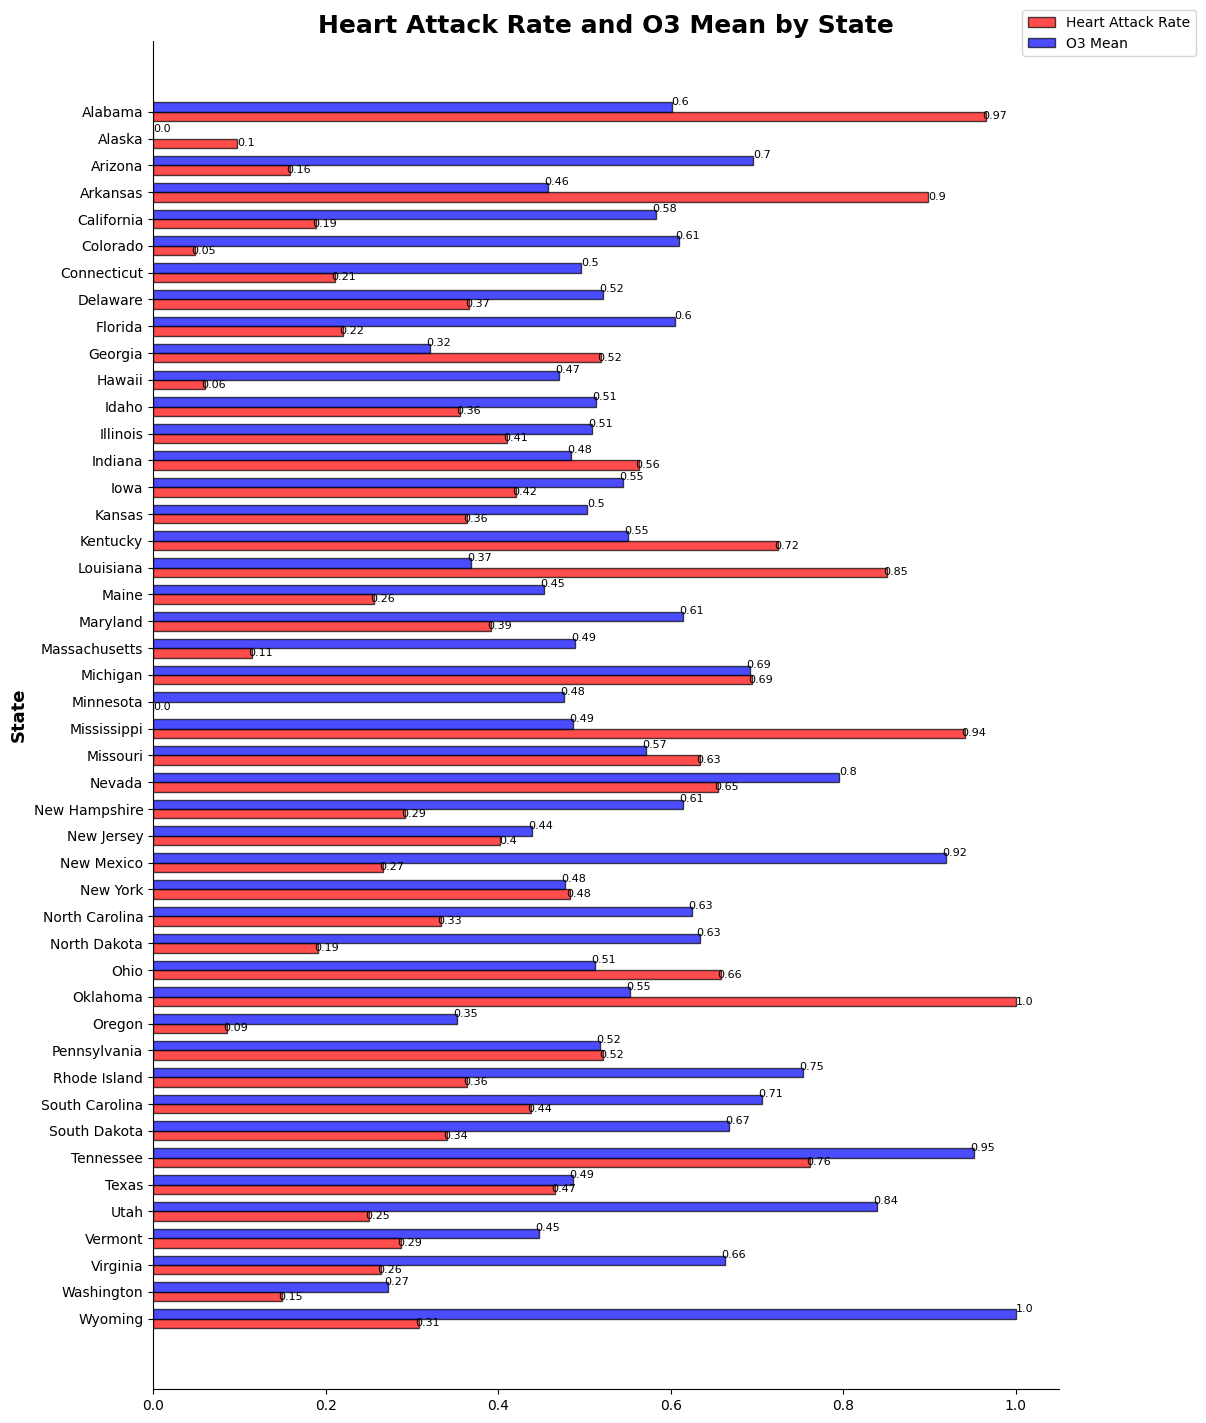

In [144]:
# Carica i dataset
heart_attack_completo = pd.read_csv('heart_completo.csv')
pollution_completo = pd.read_csv('pollution_completo.csv')

# Unisci i dataset utilizzando lo stato come chiave primaria
merged_data = pd.merge(heart_attack_completo, pollution_completo, on='State')

# Seleziona solo le colonne necessarie
merged_data = merged_data[['State', 'RATE', 'O3 Mean']]
#merged_data['O3 Mean'] *= 10000  # i valori di scala sono nella scala decimale 10, 100, 1000, 10000, 100000 ...

# Ordina gli stati inversamente
merged_data.sort_values(by='State', ascending=False,  inplace=True)

# Trova il valore massimo e minimo di RATE e O3 Mean
max_rate = merged_data['RATE'].max()
min_rate = merged_data['RATE'].min()
max_o3_mean = merged_data['O3 Mean'].max()
min_o3_mean = merged_data['O3 Mean'].min()

# Normalizza i valori di RATE e O3 Mean utilizzando la formula di normalizzazione massimo-minimo
merged_data['RATE_Normalized'] = ((merged_data['RATE'] - min_rate) / (max_rate - min_rate)) * (1 - 0) + 0
merged_data['O3 Mean_Normalized'] = ((merged_data['O3 Mean'] - min_o3_mean) / (max_o3_mean - min_o3_mean)) * (1 - 0) + 0

# Stampa i valori normalizzati
#for rate_normalized, o3_mean_normalized in zip(merged_data['RATE_Normalized'], merged_data['O3 Mean_Normalized']):
#    print("RATE Normalized:", rate_normalized, "| O3 Mean Normalized:", o3_mean_normalized)

# Crea l'istogramma con doppie barre in orizzontale
plt.figure(figsize=(12, 15))  # Imposta la dimensione della figura
bar_height = 0.35
index = range(len(merged_data['State']))
plt.barh(index, merged_data['RATE_Normalized'], bar_height, label='Heart Attack Rate', color='red', alpha=0.7, edgecolor='black')
plt.barh([i + bar_height for i in index], merged_data['O3 Mean_Normalized'], bar_height, label='O3 Mean', color='blue', alpha=0.7, edgecolor='black')
plt.ylabel('State', fontweight='bold', fontsize=13)  # Cambia l'etichetta dell'asse y in grassetto
plt.title('Heart Attack Rate and O3 Mean by State', fontweight='bold', fontsize=18)

# Imposta gli intervalli dei ticks per lo spaziamento
plt.yticks([i + bar_height / 2 for i in index], merged_data['State'], fontsize=10)  

# Aggiungi i valori normalizzati sopra le barre con maggiore spazio tra i valori e le barre e con un font più piccolo
for i, rate_normalized, o3_mean_normalized in zip(index, merged_data['RATE_Normalized'], merged_data['O3 Mean_Normalized']):
    plt.text(rate_normalized + 0.01, i, str(round(rate_normalized, 2)), ha='center', va='center', color='black', fontsize=8)
    plt.text(o3_mean_normalized + 0.01, i + bar_height + 0.2, str(round(o3_mean_normalized, 2)), ha='center', va='center', color='black', fontsize=8)  # Aggiungi uno spazio

plt.legend(loc='upper left', bbox_to_anchor=(0.85, 0.95), bbox_transform=plt.gcf().transFigure)

# Imposta lo stile degli assi e rimuovi il bordo
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.tight_layout()
plt.show()


visualizzare informazioni correlazioni tra infarti e fastfood (fare forma tabellare)

RATE significa il rapporto dei morti ogni 100.000 persone

DA QUESTO PUNTO IN POI IL CODICE PROBABILMENTE NON SERVE A NIENTE

In [ ]:
# Carica entrambi i dataset
fastfood_df = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/fastfood_completo.csv')
heart_df = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/heart_completo.csv')

# Effettua il groupby per lo stato e conta i fast food per stato
fastfood_df = fastfood_df.groupby('State').size().reset_index(name='count')

# Unisci i due dataset sulla colonna "State"
heart_fastfood = pd.merge(fastfood_df, heart_df, on="State", how="inner")

# Rimuovi le colonne specificate dal DataFrame
heart_fastfood.drop(columns=['YEAR', 'DEATHS', 'latitude', 'longitude'], inplace=True)

#CORRELAZIONE DI PEARSON TRA FASTFOOD E HEART ATTACK
correlation_coefficient= np.corrcoef(heart_fastfood['count'], heart_fastfood['RATE'])[0,1]

print(correlation_coefficient)


In [ ]:
# Carica entrambi i dataset
pollution_df = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/pollution_completo.csv')
heart_df = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/repo progetto/progetto-SNA/heart_completo.csv')

# Unisci i due dataset sulla colonna "State"
heart_pollution = pd.merge(pollution_df, heart_df, on="State", how="inner")

# Arrotonda il risultato a due cifre decimali
heart_pollution['O3 Mean'] = heart_pollution['O3 Mean'].round(5)

# Rimuovi le colonne specificate dal DataFrame
heart_pollution.drop(columns=['Year', 'DEATHS', 'latitude_y', 'longitude_y', 'CO Mean', 'SO2 Mean', 'NO2 Mean', 'YEAR', 'latitude_x', 'longitude_x'], inplace=True)

#CORRELAZIONE DI PEARSON TRA INQUINAMENTO E HEART ATTACK
correlation_coefficient= np.corrcoef(heart_pollution['O3 Mean'], heart_pollution['RATE'])[0,1]

print(correlation_coefficient)

In [ ]:
heart_fastfood_pollution = pd.merge(heart_pollution, heart_fastfood, on="State", how="inner")
heart_fastfood_pollution.drop(columns=['RATE_y'], inplace=True)

# Seleziona le colonne da normalizzare
data_to_normalize = heart_fastfood_pollution[['O3 Mean', 'RATE_x', 'count']]

# Crea un oggetto StandardScaler
scaler = StandardScaler()

# Adatta il modello e trasforma i dati
normalized_data = scaler.fit_transform(data_to_normalize)
print(normalized_data)

# Crea un nuovo dataframe con i dati normalizzati
normalized_df = pd.DataFrame(normalized_data, columns=['O3 Mean', 'RATE_x', 'count'])

# Aggiungi la colonna 'State' al dataframe normalizzato
heart_fastfood_pollution['State'] = heart_fastfood_pollution['State']

# Seleziona solo le colonne numeriche per il calcolo della correlazione
numeric_columns = heart_fastfood_pollution.select_dtypes(include=['float64', 'int64'])

# Calcola la correlazione di Pearson
correlation_matrix = numeric_columns.corr(method='pearson')

print("Matrice di correlazione di Pearson:")
print(correlation_matrix)